In [12]:
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [13]:
# 数据所在文件夹
base_dir = 'G:\dogs_and_cats'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# 训练集
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 验证集
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [14]:
from tensorflow.keras.applications import ResNet50

In [15]:
pre_train_model = ResNet50(include_top=False,
    weights='imagenet',
    input_shape=(75, 75, 3))

In [16]:
# 可以选择哪些层进行训练 人间训练好的模型中总共有len(pre_train_model.layers),如果执行下面的for循环之后 该模型中所有的权重参数将不会被更新
for layer in pre_train_model.layers:
    layer.trainable = False

In [17]:
## callbacks的作用: 相当于一个监视器，在训练过程中可以设置一些自定义项，比如提前停止，改变学习率等
"""
callbacks=[
如果两个epoch还没降低就停止：
tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=2)
可以动态改变学习率:
tf.keras.callbacks.LearningRateScheduler()
Examples:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * ops.exp(-0.1)
model = keras.models.Sequential([keras.layers.Dense(10)])
model.compile(keras.optimizers.SGD(), loss='mse')
round(model.optimizer.learning_rate, 5)

callback = keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=15, callbacks=[callback], verbose=0)
round(model.optimizer.learning_rate, 5)
]

保存模型: 断点重续
tf.keras.callbacks.ModelCheckpoint

自定义方法：
tf.keras.callbacks.Callback
"""
# 自定方法演示
class myCallback(tf.keras.callbacks.Callback):  # 继承这个类
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') >= 0.80):
            print('\nReached 80% accuracy so cancelling training!')
            self.model.stop_training = True

In [18]:
from tensorflow.keras.optimizers import Adam

In [19]:
# 为全连接层做准备
x = layers.Flatten()(pre_train_model.output)   #  这种写法等价于model.add()  (pre_train_model.output)表示上一层的输出，layers.Flatten()表示把上一层的输出做Flatten操作
# 加入全连接层， 这个需要重新训练
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
# 输出层
x = layers.Dense(1, activation='sigmoid')(x)
# 构建模型序列
model = Model(pre_train_model.input, x)
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['acc'])

In [20]:
# 数据预处理操作
train_datagen = ImageDataGenerator(rescale=1/255.#,  下面几个参数属于数据增强选项
                                    #rotation_range=40,
                                    #width_shift_range=0.3, height_shift_range=0.3,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #horizontal_flip=True
                                   )
test_datagen = ImageDataGenerator(rescale=1/255.)

In [21]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                  target_size=(75, 75),
                                  batch_size=250,
                                  # 如果是多分类问题就使用categorical
                                  class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                  target_size=(75, 75),
                                  batch_size=20,
                                  # 如果是多分类问题就使用categorical
                                  class_mode='binary')

Found 21798 images belonging to 2 classes.
Found 3202 images belonging to 2 classes.


In [22]:
# 训练模型  （加入callback模块）
callbacks = myCallback()
with tf.device('/GPU') as f:
    history = model.fit(train_generator,
                    steps_per_epoch=50,  # images >= batch_size * steps
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=20,  # images >= batch_size * steps
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/50
50/50 - 34s - loss: 5.3587 - acc: 0.5161 - val_loss: 0.7004 - val_acc: 0.4675 - 34s/epoch - 677ms/step
Epoch 2/50
50/50 - 25s - loss: 0.6796 - acc: 0.5595 - val_loss: 0.6570 - val_acc: 0.6250 - 25s/epoch - 504ms/step
Epoch 3/50
50/50 - 25s - loss: 0.6411 - acc: 0.6338 - val_loss: 0.6116 - val_acc: 0.6875 - 25s/epoch - 505ms/step
Epoch 4/50
50/50 - 22s - loss: 0.6388 - acc: 0.6278 - val_loss: 0.6117 - val_acc: 0.6925 - 22s/epoch - 442ms/step
Epoch 5/50
50/50 - 21s - loss: 0.6238 - acc: 0.6551 - val_loss: 0.6127 - val_acc: 0.6725 - 21s/epoch - 414ms/step
Epoch 6/50
50/50 - 24s - loss: 0.6165 - acc: 0.6615 - val_loss: 0.5904 - val_acc: 0.7025 - 24s/epoch - 476ms/step
Epoch 7/50
50/50 - 21s - loss: 0.6135 - acc: 0.6618 - val_loss: 0.5916 - val_acc: 0.6900 - 21s/epoch - 425ms/step
Epoch 8/50
50/50 - 21s - loss: 0.5978 - acc: 0.6806 - val_loss: 0.5686 - val_acc: 0.6825 - 21s/epoch - 411ms/step
Epoch 9/50
50/50 - 19s - loss: 0.6083 - acc: 0.6579 - val_loss: 0.6248 - val_acc: 0.6900

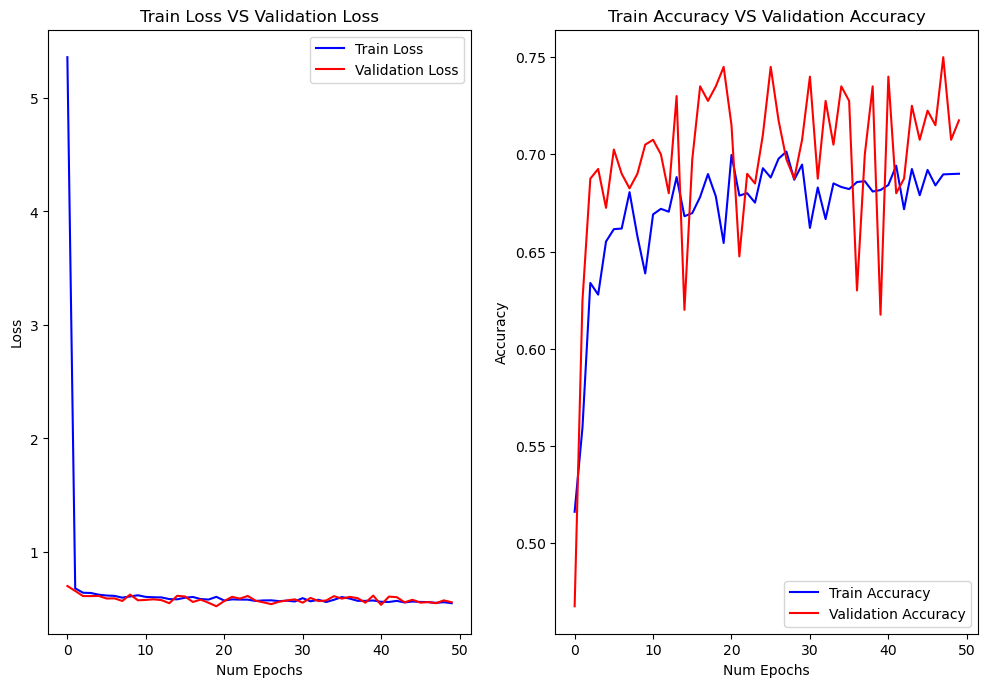

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8), dpi=100)
plt.rcParams['figure.facecolor'] = 'white'
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = history.epoch

train_acc = history.history['acc']
val_acc = history.history['val_acc']

plt.subplot(121)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.legend()
plt.xlabel('Num Epochs')
plt.ylabel('Loss')
plt.title('Train Loss VS Validation Loss')

plt.subplot(122)
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.legend()
plt.xlabel('Num Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy VS Validation Accuracy')
plt.show()